## Create nodes in Neo4j

In [ ]:
!pip install python-dotenv
!pip install langchain-community
!pip install neo4j
!pip install openai
!pip install tiktoken

In [ ]:
# Step 1: Import and Connect to Neo4j
from dotenv import load_dotenv
import os, json
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm

load_dotenv('rag.env', override=True)
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

<ipython-input-8-9cba903e572f>:13: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  kg = Neo4jGraph(


In [ ]:
# Step 2: Load cleaned 10-K JSON
from google.colab import drive
drive.mount('/content/drive')

import json
file_path = '/content/drive/MyDrive/cleaned_10k_json/AAPL_10k_cleaned.json'
with open(file_path, 'r') as f:
  doc = json.load(f)

Mounted at /content/drive


In [ ]:
# Step 3: Create nodes in Neo4j from section to paragraph
for section, paragraphs in tqdm(doc.items()):
    for para in paragraphs:
        kg.query(
            """
            MERGE (c:TextChunk {text: $text})
            SET c.section = $section
            """,
            params={"text": para.strip(), "section": section}
        )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 8/8 [2:44:56<00:00, 1237.04s/it]


## Entity Extraction

With spaCy (Named Entity Recognition)

**Basic Version**

In [ ]:
# Step 1: Install and load spaCy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

import spacy
from tqdm import tqdm
from langchain_community.graphs import Neo4jGraph

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Connect to Neo4j
kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

# Step 2: Fetch paragraphs from Neo4j
results = kg.query("""
    MATCH (c:TextChunk)
    RETURN c.text AS text, ID(c) AS id
""")

# Step 3: Process each paragraph for NER
for row in tqdm(results):
    doc = nlp(row['text'])
    entities = [(ent.text, ent.label_) for ent in doc.ents]

# Step 4: Write entities into Neo4j as nodes + relationships
    for ent_text, ent_label in entities:
        kg.query("""
            MERGE (e:Entity {name: $ent_text, type: $ent_label})
            WITH e
            MATCH (c) WHERE ID(c) = $chunk_id
            MERGE (c)-[:MENTIONS]->(e)
        """, params={
            "ent_text": ent_text,
            "ent_label": ent_label,
            "chunk_id": row['id']
        })

100%|██████████| 85/85 [00:01<00:00, 58.43it/s]


**Advanced Version**

In [ ]:
# Step 1: Install & import dependencies
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

import spacy
from spacy.matcher import PhraseMatcher
from tqdm import tqdm
from langchain_community.graphs import Neo4jGraph

# Step 2: Load NLP model and initialize matcher
nlp = spacy.load("en_core_web_sm")

# Custom risk-related phrases
risk_terms = [
    "supply chain disruption", "macroeconomic downturn", "foreign exchange risk",
    "component shortage", "regulatory changes", "inflation risk", "pandemic impact",
    "political instability", "competitive pressure", "litigation risk"
]

matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(term) for term in risk_terms]
matcher.add("RISK_TERM", patterns)

# Step 3: Connect to Neo4j
kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

# Step 4: Query paragraphs from Neo4j
results = kg.query("""
    MATCH (c:TextChunk)
    RETURN c.text AS text, ID(c) AS id
""")

# Step 5: Extract and store both standard + custom entities
for row in tqdm(results):
    text = row['text']
    chunk_id = row['id']
    doc = nlp(text)

    # Named Entity Recognition
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Phrase Matching (manual risk entity)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        entities.append((span.text, "RISK"))

    # Push into Neo4j
    for ent_text, ent_type in entities:
        kg.query("""
            MERGE (e:Entity {name: $ent_text, type: $ent_type})
            WITH e
            MATCH (c) WHERE ID(c) = $chunk_id
            MERGE (c)-[:MENTIONS]->(e)
        """, params={
            "ent_text": ent_text,
            "ent_type": ent_type,
            "chunk_id": chunk_id
        })


100%|██████████| 85/85 [00:00<00:00, 94.09it/s] 


## Relationship Identification

In [ ]:
import spacy
from collections import defaultdict

# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Step 1: Pull chunks from Neo4j
chunks = kg.query("""
    MATCH (c:TextChunk)
    RETURN c.text AS text, c.section AS section
    LIMIT 100
""")

# Step 2: Apply NER and extract entity pairs
print("Extracting entity relationships...")
pairs = []
entity_texts = set()

for row in chunks:
    doc = nlp(row['text'])
    entities = [(ent.text.strip(), ent.label_) for ent in doc.ents if ent.label_ in {"ORG", "PRODUCT", "GPE", "MONEY", "PERCENT", "DATE", "PERSON"}]

    # Store entity nodes
    for ent_text, _ in entities:
        entity_texts.add(ent_text)

    # Store co-occuring pairs (undirected, symmetric)
    for i in range(len(entities)):
        for j in range(i+1, len(entities)):
            e1, e2 = entities[i][0], entities[j][0]
            pairs.append((e1, e2))

# Step 3: Push entity nodes and relationships to Neo4j
print("Uploading entities and relationships to Neo4j...")
for name in entity_texts:
    kg.query("""
        MERGE (e:Entity {name: $name})
        """, params={"name": name})

for e1, e2 in pairs:
    kg.query("""
        MATCH (a:Entity {name: $e1}), (b:Entity {name: $e2})
        MERGE (a)-[:CO_MENTIONED_WITH]->(b)
        """, params={"e1": e1, "e2": e2})

Extracting entity relationships...
Uploading entities and relationships to Neo4j...


## Build Graph

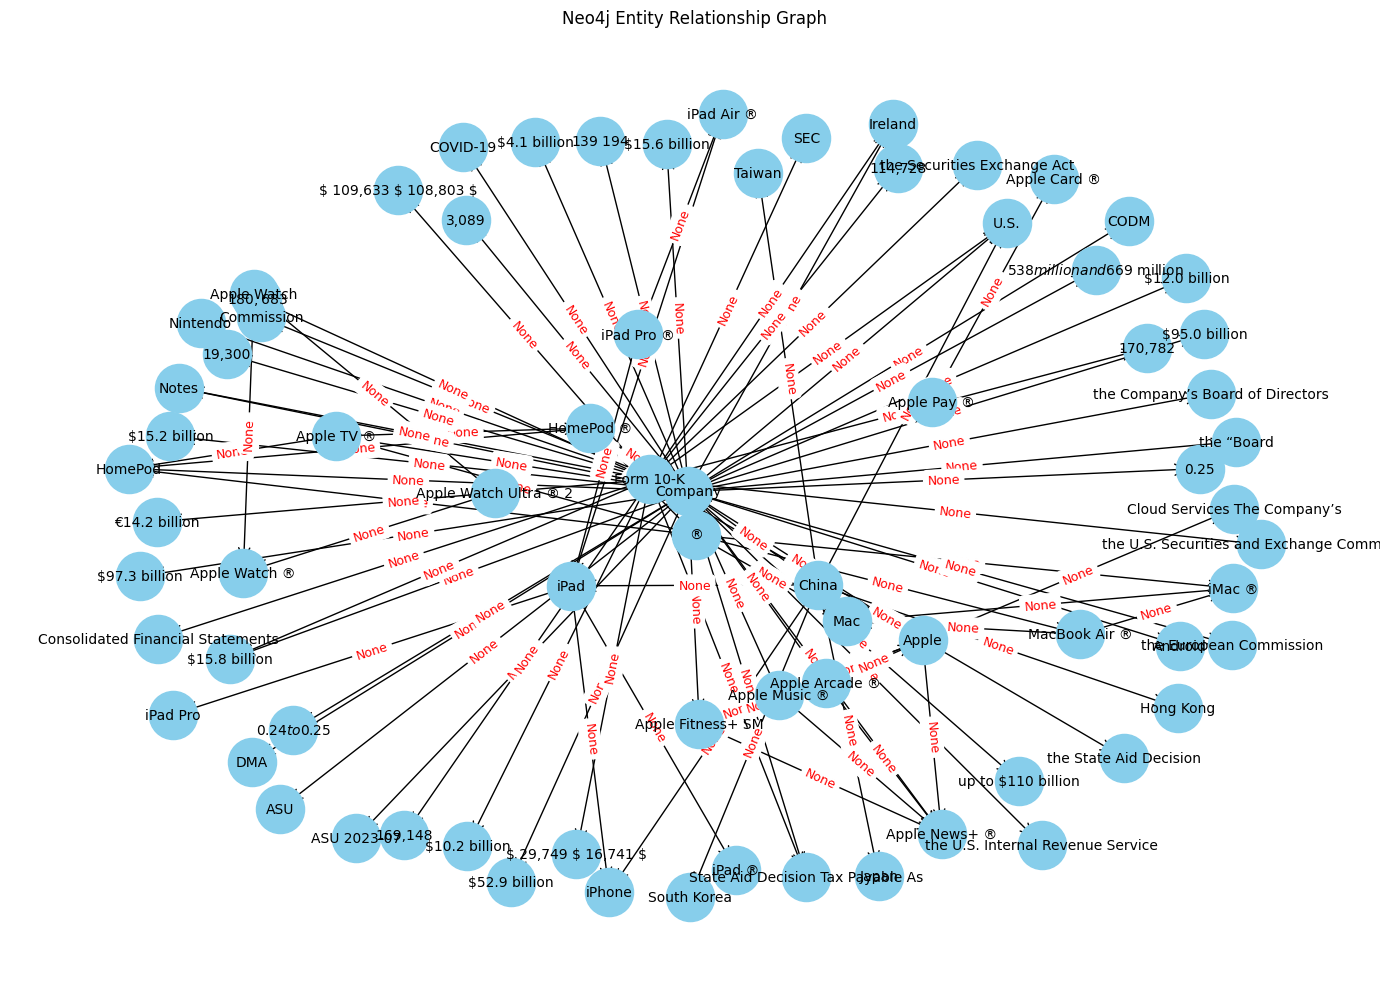

In [ ]:
# Step 1: Import
## !pip install py2neo
## !pip install networkx
## !pip install matplotlib
## !pip install python-dotenv
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Step 2: Connect to Neo4j
load_dotenv('rag.env', override=True)
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")
graph = Graph(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# Step 3: Query graph for entity-to-entity relations
query = """
MATCH (e1:Entity)-[r:CO_OCCURS_WITH]->(e2:Entity)
RETURN e1.name AS source, r.type AS relation, e2.name AS target
LIMIT 100
"""
results = graph.run(query).data()

# Step 4: Build with NetworkX
G = nx.DiGraph()
for row in results:
    G.add_edge(row['source'], row['target'], label=row['relation'])

# Step 5: Visualize
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edges and relation labels
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

plt.title("Neo4j Entity Relationship Graph")
plt.axis('off')
plt.tight_layout()
plt.show()